In [1]:
# Data preparation for Ph.D thesis
# copy from INDICATORS_DATASET_RAW_DATA_FOR_TS-GENERATOR-PARSING.ipynb
# @author: Andres L. Suarez-Cetrulo
%config IPCompleter.greedy=True
%load_ext jupyternotify
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
# Imports
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import os
import matplotlib.pyplot as plt

# Using TALib abstract API to create a dictionary of technical indicators to iterate later.
from talib import abstract

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### The first step is to run 1_rawdata_processing.py in the project QuantQuoteDataPreprocessing. 
- Run this for the desired ETF symbols, frequency and period (check in config.yaml).
- Move output files to the input directory of the next cell below ('path' val)

#### Then, parse the series (removing out of market hours)

In [4]:
# path = os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data','efts','30min-level',
#                     'IBEX','IBEX_[2017-01-01_to_2018-01-01]'])
sources = ['S&P500']
#date_ranges = ['[2014-12-01_to_2015-01-01]' ,'[2015-01-01_to_2016-01-01]', '[2016-01-01_to_2017-01-01]', 
#               '[2017-01-01_to_2018-01-01]', '[2018-01-01_to_2019-01-01]']
files = list()
level = '1min-level'
for source in sources:
    print(source)
    for file in ['spy_historical']: # ['SPY_[2017-09-22_to_2017-12-09]']:  #['spy_alphavantage_2017', 'spy_alphavantage_2018', 'spy_alphavantage_2019_2020']:
        path = os.sep.join(['C:','Users','suare','data', 'raw', 'quantquote', 'minutes', file])  # new - moving data across
        df = pd.read_csv(path+'.csv', sep=',')
#         df.rename(columns={'Date':'datetime'}, inplace=True)
#         assert False
        grouped_df = df.groupby(df.date).max()
#         early_close_dates = grouped_df[grouped_df['time'] < 1530].reset_index().date # to filter them out
#         df = df[~df['date'].isin(early_close_dates)]
        df['date'] =  pd.to_datetime(df['date'], format='%Y%m%d').dt.strftime('%Y-%m-%d')
        df['time'] = (pd.to_datetime(df['time'].astype(str).str.strip(), format='%H%M').dt.strftime('%H:%M'))
        df['datetime'] = df.date.astype(str) + ' ' + df.time.astype(str)
#         assert False
        trading_dates = df.datetime.str[:10].unique() #  list of market days
        df.index = pd.to_datetime(df.datetime)
        df.drop(columns=['date', 'time', 'datetime', 'splits', 'earnings', 'dividends'], inplace=True)    
#         df.drop(columns=['date', 'time', 'datetime', 'splits', 'earnings'], inplace=True)      # if keeping dividends    
        df.sort_index(inplace=True, ascending=True)
        print(len(df))
        ohlc_dict = {'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'}
        df = df.resample(level.split('-')[0]).agg(ohlc_dict)
        print(len(df))
        df = df.between_time('09:31','15:59')
        print(len(df))
        df = df[df.index.astype(str).str[:10].isin(trading_dates)]
        # TODO. df = df.between_time('09:31','13:00') for half days (shortened sessions / early closing)
        print(len(df))
        # Fill gaps
        df['volume'] = df['volume'].fillna(0)
        df['close'] = df['close'].ffill()
        df['open'] = df['open'].fillna(df['close'])
        df['low'] = df['low'].fillna(df['close'])
        df['high'] = df['high'].fillna(df['close'])
        path = os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data','efts',level,
                    source,'_'.join([file, 'filling_gaps'])])
        df.to_csv(path+'_market_hours.csv', sep=';')
#         os.remove(path+'_market_hours.csv')
        files.append(path+'_market_hours.csv')
# files

S&P500
2169266
11793989
3186299
2195127


In [5]:
# df['date'] = df.index.astype(str).str[:10]
# df['time'] = df.index.astype(str).str[11:]
grouped=df.groupby('date').count()
grouped[grouped['time']<388] # thus, filtering this way is not a clean solution

KeyError: 'date'

In [ ]:
df[df['date'].astype(str) == '20181123']

In [ ]:
# grouped_df = df.groupby(df.datetime.str[:10]).max()
# grouped_df[grouped_df.time < '15:00']

In [ ]:
grouped_df = df.groupby(df.datetime.str[:10]).count()
grouped_df[grouped_df['date']<250].sort_index(ascending=True)

In [ ]:
# trading_dates = df.datetime.str[:10].unique()
# len(df[df.index.astype(str).str[:10].isin(trading_dates)]) # 3186299  -> 2195127
# df[df.index == dates]

In [ ]:
# S&P500
# 2169266

In [ ]:
df[['dividends']].plot()
print(df.dividends.nunique())
# df[df.dividends!=0]
df.reset_index().groupby('dividends')['datetime'].describe()

In [ ]:
# df['date'] = df.index
# df.date = df.date.astype(str).str[:10]
# df.groupby('date').count().tail(2000)

#### Now let's define indicators, paths, and start the transformation process

In [7]:
# Creating a dictionary of technical indicators using TALib abstract API
indicators = ['sma','ema','wma','mom','stoch','macd' ,'rsi' ,'willr',
              'adosc' ,'cci','adx','aroon' ,'bbands','obv' ,'trima',
              'roc' ,'rocr','stochf','medprice','typprice','wclprice',
              'atr','macdfix','mfi' ,'sar' ,'ppo']

def get_indicator(ind: str):
    return abstract.Function(ind)

# Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/

In [8]:
import subprocess
# Define this to parse the CSVs to ARFF later automatically
def create_arff_file(filename, output=None):
    java_mem = '-Xmx3074m'
    filename = filename.replace('.csv', '')
    if output is None:
        output=filename
    else:
        output = output.replace('.csv', '')
    wekadev_libpath = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\lib\\weka-dev-3.7.12.jar'
    command = ['java', java_mem, '-classpath', wekadev_libpath,
               'weka.core.converters.CSVLoader', filename + '.csv', '>', output + '.arff']
    f = open(filename + '.arff', "w")
    subprocess.call(command, stdout=f)
    print('If the arff is not generated, run the next in the terminal.')
    print(str(' '.join(command)))

In [9]:
# Paths for symbols (not eft)
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data'])
# '/Users/asuarez/Downloads'
SOURCE_PATH=DATA_PATH # +'raw\\alpha_vantage\\S&P500\\symbols\\AAPL\\'  # 'raw/alpha_vantage/'
RESULT_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output']) # +'analysis\\'+SYMBOL.lower()+'\\'

# List of dates for files to be loaded
# raw_datasets = ['aapl\\APPLE_[2018-08-01_to_2018-09-11]_5min.csv',
#                   'btc\\BITCOIN_[2019-07-01_to_2019-07-15]_5min.csv',
#                   'xrp\\RIPPLE_[2019-07-01_to_2019-08-01]_5min.csv',
#                   'efts\\5min-level\\DOWJONES\\DOWJONES_[2015-08-01_to_2015-08-31]_market_hours.csv']
raw_datasets = ['efts\\'+level+'\\DOWJONES\\DOWJONES_[2015-01-01_to_2016-01-01]_market_hours.csv']
    
filename = raw_datasets[0] # 'timeseries_created_21-10-2019' # 'timeseries_created_1571527428'
FIELD = 'close' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'

file = os.sep.join([SOURCE_PATH, filename])
RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_indicators_best_17052020.csv'])

In [19]:
# Open file
df=pd.read_csv(file, sep=';')
print(df.head())

df['close'] = df[FIELD]
df.close.head()

              datetime      open      high       low    close   volume  gap  \
0  2015-01-02 09:30:00  178.6200  178.7300  178.5601  178.660  84826.0  0.0   
1  2015-01-02 09:31:00  178.6800  178.7154  178.5701  178.690  19078.0  0.0   
2  2015-01-02 09:32:00  178.7099  178.8040  178.6800  178.804  12179.0  0.0   
3  2015-01-02 09:33:00  178.7950  178.8900  178.7700  178.890  16965.0  0.0   
4  2015-01-02 09:34:00  178.8900  178.9100  178.8300  178.870  22910.0  0.0   

    timestamp  
0  1420191000  
1  1420191060  
2  1420191120  
3  1420191180  
4  1420191240  


0    178.660
1    178.690
2    178.804
3    178.890
4    178.870
Name: close, dtype: float64

In [19]:
#Add parameters to transform in TS
timeseries=['close', 'open', 'high', 'low']
#Length of the TS. How many values do we keep per serie. 
# e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
length = 5

# Add lagged times
for column in timeseries:
    #df[column+'_t']=df[column]
    for i in range(1,length):
        df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed
    #del drops the delected df column
    #del df[column]
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,open_t-3,open_t-4,high_t-1,high_t-2,high_t-3,high_t-4,low_t-1,low_t-2,low_t-3,low_t-4
0,2015-01-02 09:30:00,178.6200,178.7300,178.5601,178.660,84826.0,0.0,1420191000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02 09:31:00,178.6800,178.7154,178.5701,178.690,19078.0,0.0,1420191060,178.660,NaN,...,NaN,NaN,178.7300,NaN,NaN,NaN,178.5601,NaN,NaN,NaN
2,2015-01-02 09:32:00,178.7099,178.8040,178.6800,178.804,12179.0,0.0,1420191120,178.690,178.660,...,NaN,NaN,178.7154,178.7300,NaN,NaN,178.5701,178.5601,NaN,NaN
3,2015-01-02 09:33:00,178.7950,178.8900,178.7700,178.890,16965.0,0.0,1420191180,178.804,178.690,...,178.62,NaN,178.8040,178.7154,178.7300,NaN,178.6800,178.5701,178.5601,NaN
4,2015-01-02 09:34:00,178.8900,178.9100,178.8300,178.870,22910.0,0.0,1420191240,178.890,178.804,...,178.68,178.62,178.8900,178.8040,178.7154,178.73,178.7700,178.6800,178.5701,178.5601


In [30]:
# all the numbers here and below assume a default time period for ta params of 10 mins averages
# change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
# in that case change as well the time tag '_10' with the corresponding one.
default_timerange=10
# Set extra timeranges for moving averages
extra_timeranges=[default_timerange/2, default_timerange, default_timerange*2, default_timerange*3]

# ###########################################
# Iterate and run list of indicators selected
# All of them produced for 25 prior mins of data 
# ###########################################
for ind in list(indicators):
    if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
        # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
        if ind in ['ema','sma','trima']:
            for timerange in extra_timeranges:
                df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
        elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
            df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
        # Otherwise check the list of columns and return all
        else: 
            key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
            for j in range(0,len(list(key_output.columns))):
                df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,stochf_fastd,medprice_10,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10
0,2015-01-02 09:30:00,178.6200,178.7300,178.5601,178.660,84826.0,0.0,1420191000,NaN,NaN,...,NaN,178.64505,178.650033,178.652525,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02 09:31:00,178.6800,178.7154,178.5701,178.690,19078.0,0.0,1420191060,178.660,NaN,...,NaN,178.64275,178.658500,178.666375,NaN,NaN,NaN,NaN,178.560100,NaN
2,2015-01-02 09:32:00,178.7099,178.8040,178.6800,178.804,12179.0,0.0,1420191120,178.690,178.660,...,NaN,178.74200,178.762667,178.773000,NaN,NaN,NaN,NaN,178.563206,NaN
3,2015-01-02 09:33:00,178.7950,178.8900,178.7700,178.890,16965.0,0.0,1420191180,178.804,178.690,...,NaN,178.83000,178.850000,178.860000,NaN,NaN,NaN,NaN,178.570100,NaN
4,2015-01-02 09:34:00,178.8900,178.9100,178.8300,178.870,22910.0,0.0,1420191240,178.890,178.804,...,NaN,178.87000,178.870000,178.870000,NaN,NaN,NaN,NaN,178.589294,NaN


In [31]:
def set_label(row):
    if row['close_t+1'] > row['close']: return 1
    else: return 0

# One minute ahead closing price
df['close_t+1']=df['close'].shift(-1)

# Creating label/y to be predicted / independent (predicted) feature 'y' 
df['label'] = df.apply(set_label, axis=1)
# df.drop(columns=['n_row', 'new_switch', 'cur_switch', 'current_model_id', 'new_model_id', 
#                  'weights', 'ts', 'ret_ts', 'ts_n1_pre', 'ts_n2_pre', 'ts_n1_post', 'ts_n2_post'], inplace=True)
df.dropna(inplace=True)
df.head()

,datetime,open,high,low,close,volume,gap,timestamp,close_t-1,close_t-2,...,typprice_10,wclprice_10,atr_10,macdfix_macd,macdfix_macdsignal,macdfix_macdhist,sar_10,ppo_10,close_t+1,label
33,2015-01-02 10:03:00,178.82,179.03,178.82,179.01,23499.0,0.0,1420192980,178.78,178.83,...,178.953333,178.9675,0.120229,-0.006001,0.034851,-0.040852,179.177535,-0.011465,178.96,0
34,2015-01-02 10:04:00,179.03,179.04,178.87,178.96,10598.0,0.0,1420193040,179.01,178.78,...,178.956667,178.9575,0.125206,-0.009356,0.026010,-0.035366,179.148883,-0.019139,178.93,0
35,2015-01-02 10:05:00,178.95,178.97,178.92,178.93,2320.0,0.0,1420193100,178.96,179.01,...,178.940000,178.9375,0.117686,-0.014139,0.017980,-0.032119,179.121950,-0.027590,178.85,0
36,2015-01-02 10:06:00,178.90,178.90,178.81,178.85,20954.0,0.0,1420193160,178.93,178.96,...,178.853333,178.8525,0.117917,-0.023740,0.009636,-0.033376,179.096633,-0.032031,178.75,0
37,2015-01-02 10:07:00,178.87,178.88,178.71,178.75,14947.0,0.0,1420193220,178.85,178.93,...,178.780000,178.7725,0.123125,-0.038522,0.000004,-0.038527,179.072835,-0.038979,178.78,1


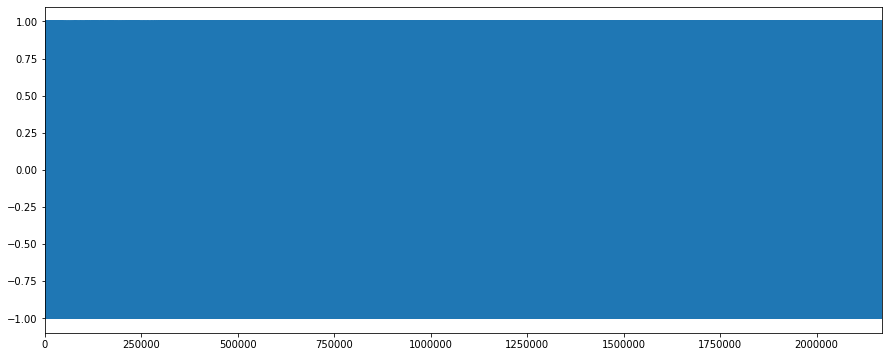

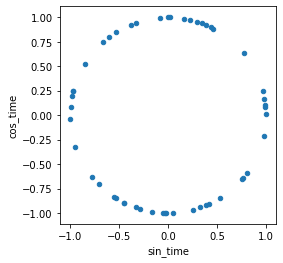

In [53]:
# Encoding cyclical continuous features for the trading day (6.5h a day except for shortened sessions)
start_market = 34200.0
df['seconds'] = (pd.to_datetime(df.datetime) - pd.to_datetime(df.datetime.str[:10])).dt.total_seconds() - start_market
seconds_trading_day = 57600.0-start_market  # specific to US EFTs, and not considering shortened trading sessions (2 per year).
df['sin_time'] = np.sin(2*np.pi*df.seconds/seconds_trading_day)
df['cos_time'] = np.cos(2*np.pi*df.seconds/seconds_trading_day)
df.cos_time.plot(figsize=(15,6))
df.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal');

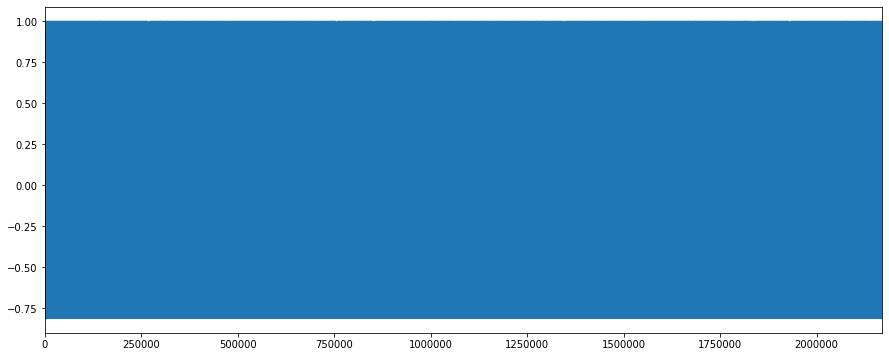

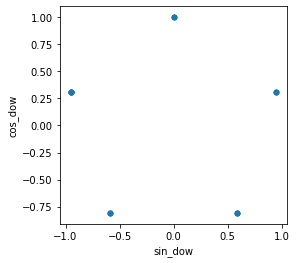

In [54]:
# Day of the week (cyclical also, for weeks of 5 days)
df['dow'] = pd.to_datetime(df.datetime).dt.dayofweek
df['sin_dow'] = np.sin(2*np.pi*df.dow/5)
df['cos_dow'] = np.cos(2*np.pi*df.dow/5)
df.cos_dow.plot(figsize=(15,6))
df.sample(50).plot.scatter('sin_dow','cos_dow').set_aspect('equal');

In [104]:
# Select columns for output
# columns_selected=['rsi_10' ,'mom_10','ema_10','ema_20','ema_30',
#                  'sma_10','sma_20','sma_30','wma_10','wma_20','wma_30',
#                  'trima_10','trima_20','trima_30',
#                  'roc_10','rocr_10','ppo_10',
#                  'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  'label']
# df['label'] = df['binary_label']
# columns_selected=[# 'datetime',
#                  'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
#                  'stoch_slowk','stoch_slowd',
#                  'sma_5','sma_10','sma_20','sma_30',
#                  'wma_5','wma_10','wma_20','wma_30',
#                  'ema_5','ema_10','ema_20','ema_30',
#                  'trima_5','trima_10','trima_20','trima_30',
#                  'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
#                  'roc_10','rocr_10','stochf_fastd','stochf_fastk',
#                  'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
#                  'atr_10','macdfix_macd','sar_10',
#                  # 'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
#                  # 'close','close_t-1','close_t-2','close_t-3','close_t-4',
#                  # 'high','high_t-1','high_t-2','high_t-3','high_t-4',
#                  # 'open','open_t-1','open_t-2','open_t-3','open_t-4',
#                  # 'low','low_t-1','low_t-2','low_t-3','low_t-4',
#                  # 'binary_label',
#                  'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
#    
# best pool found through indicators grid search script
columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
                    'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
                    'aroon_aroondown','aroon_aroonup','label']

# Export processed data
output = pd.DataFrame(df, columns=columns_selected)
output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
create_arff_file(RESULT_FILEPATH_PROCESSED) # export in ARFF

# Printing classes distributions
print("Class distribution: ")
label_zero=len(df[df['label'] == 0])
label_one=len(df[df['label'] == 1])
#print(label_zero)
#print(label_one)
print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

%notify -m "Parsing is finished"

If the arff is not generated, run the next in the terminal.
java -Xmx3074m -classpath C:\Users\suare\Workspace\phd_cetrulin\moa-2017.06-sources\lib\weka-dev-3.7.12.jar weka.core.converters.CSVLoader C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\SPY_[2017-09-22_to_2017-12-09]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.csv > C:\Users\suare\PycharmProjects\RegimeSwitchingSeriesGenerator\output\SPY_[2017-09-22_to_2017-12-09]_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.arff
Class distribution: 
0 in 0.5473382831076818%
1 in 0.45266171689231816%


<IPython.core.display.Javascript object>

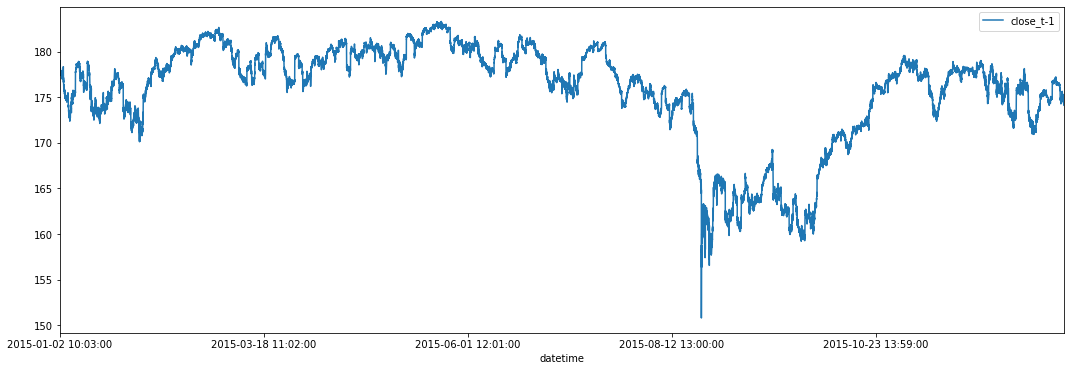

In [33]:
# Now plot close price and volume overtime.
import matplotlib.pyplot as plt
import pandas as pd

df.set_index('datetime',drop=True).plot(y=["close_t-1"], figsize=(18,6))
plt.show()

In [34]:
df.columns

Index(['datetime', 'open', 'high', 'low', 'close', 'volume', 'gap',
       'timestamp', 'close_t-1', 'close_t-2', 'close_t-3', 'close_t-4',
       'open_t-1', 'open_t-2', 'open_t-3', 'open_t-4', 'high_t-1', 'high_t-2',
       'high_t-3', 'high_t-4', 'low_t-1', 'low_t-2', 'low_t-3', 'low_t-4',
       'sma_5', 'sma_10', 'sma_20', 'sma_30', 'ema_5', 'ema_10', 'ema_20',
       'ema_30', 'wma_10', 'mom_10', 'stoch_slowk', 'stoch_slowd', 'macd_macd',
       'macd_macdsignal', 'macd_macdhist', 'rsi_10', 'willr_10', 'cci_10',
       'adx_10', 'aroon_aroondown', 'aroon_aroonup', 'bbands_upperband',
       'bbands_middleband', 'bbands_lowerband', 'trima_5', 'trima_10',
       'trima_20', 'trima_30', 'roc_10', 'rocr_10', 'stochf_fastk',
       'stochf_fastd', 'medprice_10', 'typprice_10', 'wclprice_10', 'atr_10',
       'macdfix_macd', 'macdfix_macdsignal', 'macdfix_macdhist', 'sar_10',
       'ppo_10', 'close_t+1', 'label'],
      dtype='object')

In [46]:
# # Creating a dictionary of technical indicators using TALib abstract API
# indicator = {}
# # Add as many indicators as necessary: see all indicators in https://mrjbq7.github.io/ta-lib/
# indicator['sma']=abstract.Function('sma') # Simple Moving Average
# indicator['ema']=abstract.Function('ema') # Exponential Moving Average
# indicator['mom']=abstract.Function('mom') # Momentum
# indicator['stoch']=abstract.Function('stoch') # Stochastic (returns K and D)
# indicator['macd']=abstract.Function('macd') # Moving Average Convergence/Divergence
# indicator['rsi']=abstract.Function('rsi') # Relative Strength Index
# indicator['willr']=abstract.Function('willr') # Williams' %R
# indicator['adosc']=abstract.Function('adosc') # Chaikin A/D Oscillator
# indicator['cci']=abstract.Function('cci') # Commodity Channel Index

# # --- --- 

# # extra columns
# indicator['adx']=abstract.Function('adx') # Average Directional Movement Index
# indicator['aroon']=abstract.Function('aroon') # Aroon
# indicator['bbands']=abstract.Function('bbands') # Bollinger Bands
# indicator['obv']=abstract.Function('obv') # On Balance Volume
# # 
# indicator['trima']=abstract.Function('trima') # Triangular Moving Average
# indicator['roc']=abstract.Function('roc') # Rate of change : ((price/prevPrice)-1)*100
# indicator['rocr']=abstract.Function('rocr') # Rate of change ratio: (price/prevPrice)
# indicator['stochf']=abstract.Function('stochf') # Stochastic fast (returns K and D)
# indicator['adosc']=abstract.Function('adosc') # Chaikin A/D Oscillator
# indicator['medprice']=abstract.Function('medprice') # Median Price
# indicator['typprice']=abstract.Function('typprice') # Typical Price
# indicator['wclprice']=abstract.Function('wclprice') # Weighted Close Price
# indicator['atr']=abstract.Function('atr') # Average True Range
# indicator['macdfix']=abstract.Function('macdfix') # #Moving Average Convergence/Divergence Fix 12/26
# indicator['mfi']=abstract.Function('mfi') # Money Flow Index

In [14]:
df.head()

,open,high,low,close,volume
datetime,,,,,
1998-01-02 09:31:00,64.9236,64.9236,64.9236,64.9236,97424.60
1998-01-02 09:32:00,65.0103,65.0103,64.9236,64.9436,31325.70
1998-01-02 09:33:00,65.0503,65.0503,64.9436,65.0303,32075.20
1998-01-02 09:34:00,64.9703,64.9703,64.9703,64.9703,1498.84
1998-01-02 09:35:00,65.0170,65.0303,64.9703,64.9703,17536.40


Start efts\1min-level\S&P500\spy_historical_filling_gaps_market_hours.csv
                   datetime     open     high      low    close    volume
196056  2000-01-03 09:31:00  101.267  101.267  101.267  101.267  252385.0
196057  2000-01-03 09:32:00  101.267  101.267  101.096  101.096  223545.0
196058  2000-01-03 09:33:00  101.096  101.267  100.966  101.267   62803.5
196059  2000-01-03 09:34:00  101.096  101.267  100.884  100.884   29425.4
196060  2000-01-03 09:35:00  100.987  101.267  100.905  100.966   18299.4
sma
sma_5
sma_10
sma_20
sma_30
ema
ema_5
ema_10
ema_20
ema_30
wma
mom
stoch
macd
rsi
willr
adosc
cci
adx
aroon
bbands
obv
trima
trima_5
trima_10
trima_20
trima_30
roc
rocr
stochf
medprice
typprice
wclprice
atr
macdfix
mfi
sar
ppo
             datetime     open     high      low    close      volume  \
0 2000-01-03 10:05:00  100.283  100.331  100.242  100.242     731.976   
1 2000-01-03 10:06:00  100.283  100.283  100.181  100.242  149762.000   
2 2000-01-03 10:07:00  100.393  1

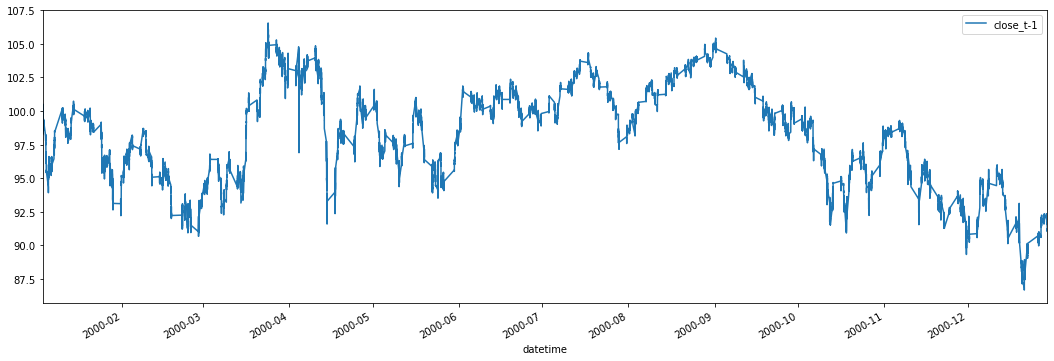

Number of instances: 89208
Class distribution: 
0 in 0.6029616177921263%
1 in 0.39703838220787374%


<IPython.core.display.Javascript object>

Start efts\1min-level\S&P500\spy_historical_filling_gaps_market_hours.csv
                   datetime     open     high      low    close    volume
294084  2001-01-02 09:31:00  91.1172  91.1379  91.0344  91.1172  582805.0
294085  2001-01-02 09:32:00  90.9861  91.1172  90.9446  90.9446   19557.2
294086  2001-01-02 09:33:00  90.9861  91.1172  90.8480  90.9308   95033.6
294087  2001-01-02 09:34:00  90.8135  90.8480  90.7721  90.7721   22164.9
294088  2001-01-02 09:35:00  90.7721  90.8342  90.6616  90.6616   50848.8
sma
sma_5
sma_10
sma_20
sma_30
ema
ema_5
ema_10
ema_20
ema_30
wma
mom
stoch
macd
rsi
willr
adosc
cci
adx
aroon
bbands
obv
trima
trima_5
trima_10
trima_20
trima_30
roc
rocr
stochf
medprice
typprice
wclprice
atr
macdfix
mfi
sar
ppo
             datetime     open     high      low    close     volume  \
0 2001-01-02 10:05:00  90.5236  90.5995  90.4822  90.4822    7678.02   
1 2001-01-02 10:06:00  90.5236  90.5236  90.3441  90.3441  120096.00   
2 2001-01-02 10:07:00  90.3924  90.5

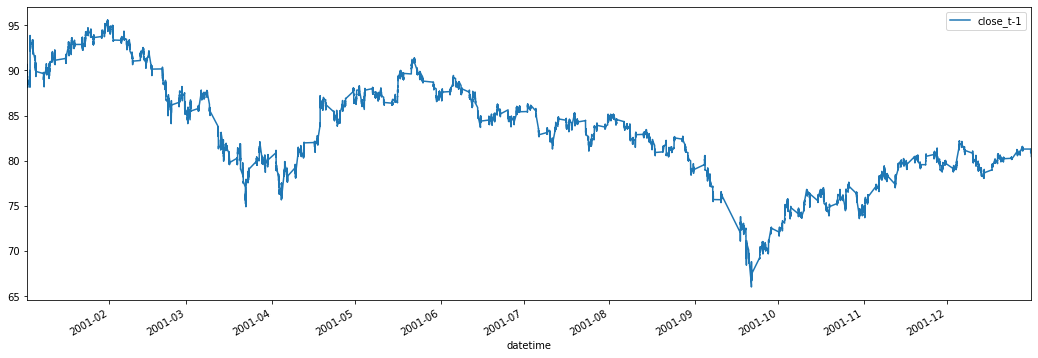

Number of instances: 87792
Class distribution: 
0 in 0.5471683069072353%
1 in 0.4528316930927647%


<IPython.core.display.Javascript object>

Start efts\1min-level\S&P500\spy_historical_filling_gaps_market_hours.csv
                   datetime     open     high      low    close    volume
390556  2002-01-02 09:31:00  80.4332  80.4542  80.3982  80.4472   69230.4
390557  2002-01-02 09:32:00  80.4122  80.4752  80.4122  80.4752   58216.4
390558  2002-01-02 09:33:00  80.4682  80.4891  80.4052  80.4472   86394.9
390559  2002-01-02 09:34:00  80.4542  80.4542  80.4122  80.4542   27606.3
390560  2002-01-02 09:35:00  80.4262  80.4682  80.3982  80.4682  322264.0
sma
sma_5
sma_10
sma_20
sma_30
ema
ema_5
ema_10
ema_20
ema_30
wma
mom
stoch
macd
rsi
willr
adosc
cci
adx
aroon
bbands
obv
trima
trima_5
trima_10
trima_20
trima_30
roc
rocr
stochf
medprice
typprice
wclprice
atr
macdfix
mfi
sar
ppo


In [ ]:
# BATCH

# Paths for symbols
DATA_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','data'])
SOURCE_PATH=DATA_PATH 
RESULT_PATH=os.sep.join(['C:','Users','suare','PycharmProjects','RegimeSwitchingSeriesGenerator','output']) 

modes = ['indicators_best', 'indicators_best_and_times', 'indicators_fullset']
sets = ['mahalanobis', 'dev', 'train'] #'mahalanobis', 'dev'] #, 'train']  # dates hardcoded later.

for mode in modes:
    for file in files:
        for dataset in sets:
            filename = file.replace(SOURCE_PATH+os.sep,'')
            FIELD = 'close' # price->'ts' returns->'ret_ts' ts_with_added_noise-> 'ts_n2_post'
            print(f'Start {filename}')

            file = os.sep.join([SOURCE_PATH, filename])
    #         RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_'+level+f'_indicators_best_no_filling_gaps_{dataset}_05062020.csv'])
            RESULT_FILEPATH_PROCESSED = os.sep.join([RESULT_PATH, filename.split(os.sep)[-1].replace('.csv','')+'_'+level+f'{dataset}_{mode}_23062020.csv'])

            # Open file
            df=pd.read_csv(file, sep=';')

            # Get date range for the current set (TODO: add to adict so if else conditions are not required and can be soecufued at the start)
            if dataset == 'mahalanobis':
                # 1998
                # df = df[df.datetime.astype('str') <= '1998-12-31 16:00:00']  # Mahalanobis Set
                # 2000
                df = df[(df.datetime.astype('str') > '1999-12-31 16:00:00') & (df.datetime.astype('str') <= '2000-12-31 16:00:00')]
                # 2007
#                 df = df[(df.datetime.astype('str') > '2006-12-31 16:00:00') & (df.datetime.astype('str') <= '2007-12-31 16:00:00')]
            elif dataset == 'dev':
                # 1999
                # df = df[(df.datetime.astype('str') > '1998-12-31 16:00:00') & (df.datetime.astype('str') <= '1999-12-31 16:00:00')]
                # 2001
                df = df[(df.datetime.astype('str') > '2000-12-31 16:00:00') & (df.datetime.astype('str') <= '2001-12-31 16:00:00')]
                # 2008
#                 df = df[(df.datetime.astype('str') > '2007-12-31 16:00:00') & (df.datetime.astype('str') <= '2008-12-31 16:00:00')]
            elif dataset == 'train': 
                # 2000-2020/05
#               df = df[df.datetime.astype('str') > '1999-12-31 16:00:00']
                # 2002-2020/05
                df = df[df.datetime.astype('str') > '2001-12-31 16:00:00']
                # 2009-2020/05
#                 df = df[df.datetime.astype('str') > '2008-12-31 16:00:00']
            else:
                assert False, 'please, add a proper set name. either Mahalanobis, dev or train.'


            print(df.head())
    #         assert False
            df=df.drop_duplicates(['datetime','open','high','low','close','volume']) 

            #Add parameters to transform in TS
            timeseries=['close', 'open', 'high', 'low']
            #Length of the TS. How many values do we keep per serie. 
            # e.g. 1 -> t / 2 -> t,t-1 / 3 -> t,t-1,t-2 / 4 -> t,t-1,t-2,t-3
            length = 5

            # Add lagged times
            for column in timeseries:
                for i in range(1,length):
                    df[column+'_t-'+str(i)]=df[column].shift(i) #it could also be sorted and group by if needed


            # all the numbers here and below assume a default time period for ta params of 10 mins averages
            # change the other numbers (params of 5min and 20min and theremoval of 20 first mins of the day below) if the mins number is changed.
            # in that case change as well the time tag '_10' with the corresponding one.
            default_timerange=10
            # Set extra timeranges for moving averages
            extra_timeranges=[default_timerange//2, default_timerange, default_timerange*2, default_timerange*3]

            # ###########################################
            # Iterate and run list of indicators selected
            # All of them produced for 25 prior mins of data 
            # ###########################################    
            for ind in list(indicators):
                print(ind)
                if ind not in ['adosc', 'obv', 'mfi']:  # avoiding indicators that need volume
                    # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
                    if ind in ['ema','sma','trima']:
                        for timerange in extra_timeranges:
                            print(ind+'_'+str(int(timerange)))
                            df[ind+'_'+str(int(timerange))] = get_indicator(ind)(df, timeperiod=timerange) 
                    elif ind not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
                        df[ind+'_'+str(int(default_timerange))] = get_indicator(ind)(df, timeperiod=(default_timerange))
                    # Otherwise check the list of columns and return all
                    else: 
                        key_output=get_indicator(ind)(df, timeperiod=(default_timerange)) #, price='close')
                        for j in range(0,len(list(key_output.columns))):
                            df[ind+'_'+key_output.columns[int(j)]] = key_output[key_output.columns[j]]
        #     for key in list(indicator.keys()):
        #         # For indicators that only return one column (this will need to be modified depending on the selection of indicators)
        #         if key in ['ema','sma','trima']:
        #             df[key+'_'+str(default_timerange//2)]=indicator[key](df, timeperiod=(default_timerange/2)) 
        #             df[key+'_'+str(default_timerange)]=indicator[key](df, timeperiod=(default_timerange)) 
        #             df[key+'_'+str(default_timerange*2)]=indicator[key](df, timeperiod=(default_timerange*2))     
        #         elif key not in ['bbands','aroon','stoch','macd','macdfix','stochf']:
        #             df[key+'_'+str(default_timerange)]=indicator[key](df, timeperiod=(default_timerange))
        #         # Otherwise check the list of columns and return all
        #         else: 
        #             key_output=indicator[key](df, timeperiod=(default_timerange)) #, price='close')
        #             for j in range(0,len(list(key_output.columns))):
        #                 df[key+'_'+key_output.columns[j]] = key_output[key_output.columns[j]]

            def set_label(row):
                if row['close_t+1'] > row['close']: return 1
                else: return 0

            # One minute ahead closing price
            df['close_t+1']=df['close'].shift(-1)
        #     df['close_t+1']=df['close'].shift(-1)

        #     def func(row):
        #         if row['close_t+1'] > row['close']:
        #             return 1
        #         else:
        #             return 0

            # Creating label/y to be predicted / independent (predicted) feature 'y' 
            df['label'] = df.apply(set_label, axis=1)
        #     df['label'] = df.apply(func, axis=1)

            df.dropna(inplace=True)

            # Encoding cyclical continuous features for the trading day (6.5h a day except for shortened sessions)
            start_market = 34200.0 # 9:30am
            end_market = 57600.0 # 04:00pm
            df['seconds'] = (pd.to_datetime(df.datetime) - pd.to_datetime(df.datetime.str[:10])).dt.total_seconds() - start_market
            seconds_trading_day = end_market - start_market  # specific to US EFTs, and not considering shortened trading sessions (2 per year).
            df['sin_time'] = np.sin(2*np.pi*df.seconds/seconds_trading_day)
            df['cos_time'] = np.cos(2*np.pi*df.seconds/seconds_trading_day)
        #     df.cos_time.plot(figsize=(15,6))
        #     df.sample(50).plot.scatter('sin_time','cos_time').set_aspect('equal');

            # Day of the week (cyclical also, for weeks of 5 days)
            df['dow'] = pd.to_datetime(df.datetime).dt.dayofweek
            df['sin_dow'] = np.sin(2*np.pi*df.dow/5)
            df['cos_dow'] = np.cos(2*np.pi*df.dow/5)
        #     df.cos_dow.plot(figsize=(15,6))
        #     df.sample(50).plot.scatter('sin_dow','cos_dow').set_aspect('equal');

            # Select columns for output
            if mode == 'indicators_best':
                # best pool found through indicators grid search script
                columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd',
                                    'sma_5','sma_10', 'wma_10','ema_10','trima_10','adx_10',
                                    'bbands_upperband','bbands_lowerband','roc_10', 'aroon_aroondown','aroon_aroonup', 
                                    'label']
            elif mode == 'indicators_best_and_times':
                columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd',
                                    'sma_5','sma_10', 'wma_10','ema_10','trima_10','adx_10',
                                    'bbands_upperband','bbands_lowerband','roc_10', 'aroon_aroondown','aroon_aroonup', 
                                    'cos_time', 'cos_dow', 'label']
    #         columns_selected = ['rsi_10','willr_10','macd_macd','cci_10','mom_10','stoch_slowk','stoch_slowd','sma_5','sma_10',
    #                             'wma_10','ema_10','trima_10','adx_10','bbands_upperband','bbands_lowerband','roc_10',
    #                             'aroon_aroondown','aroon_aroonup', 'cos_time', 'cos_dow', 'dividends', 'label']
            elif mode == 'indicators_fullset':
                columns_selected=[# 'datetime',
                                 'rsi_10','willr_10','macd_macd' ,'cci_10','mom_10',
                                 'stoch_slowk','stoch_slowd',
                                 'sma_5','sma_10','sma_20','sma_30',
                                 'wma_5','wma_10','wma_20','wma_30',
                                 'ema_5','ema_10','ema_20','ema_30',
                                 'trima_5','trima_10','trima_20','trima_30',
                                 'adx_10','bbands_upperband','bbands_middleband','bbands_lowerband',
                                 'roc_10','rocr_10','stochf_fastd','stochf_fastk',
                                 'aroon_aroondown','aroon_aroonup','medprice_10','typprice_10','wclprice_10',
                                 'atr_10','macdfix_macd','sar_10',
                                 'adosc_10', 'obv_10', 'mfi_10', 'ppo_10', ########## commented out previosly
                                 'volume','volume_t-1','volume_t-2','volume_t-3','volume_t-4',
                                 'close','close_t-1','close_t-2','close_t-3','close_t-4',
                                 'high','high_t-1','high_t-2','high_t-3','high_t-4',
                                 'open','open_t-1','open_t-2','open_t-3','open_t-4',
                                 'low','low_t-1','low_t-2','low_t-3','low_t-4',
                                 'cos_time', 'sin_time', 'cos_dow', 'sin_dow',
        #                          # 'binary_label',
                                 'label'] #,'gap_t+1','close_t+1'] # + ['adosc_10', 'obv_10', 'mfi_10', 'ppo_10']
        #     columns_selected = ['datetime', 'sma_5','ema_5','sma_20','ema_20','adosc_10','macd_macd','willr_10','stoch_slowk','stoch_slowd','cci_10','ema_10','rsi_10','sma_10','mom_10', 'label']

            # indicators have dependendies up to 45 mins before. removing records that may look at pre-market or at the previous date
            df.datetime = pd.to_datetime(df.datetime)
            df.set_index('datetime', drop=True, inplace=True)
            df = df.between_time('10:05','15:58').reset_index()

            # Export processed data
            print(df.head())
            print(len(df))
            print(RESULT_FILEPATH_PROCESSED)
            print('===========================')
            print('===========================')
            output = pd.DataFrame(df, columns=columns_selected) # [df['datetime'] >= '2017-09-25 14:07:00']
            output.to_csv(RESULT_FILEPATH_PROCESSED, sep=',', encoding='utf-8', index = False)
            devsets_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_financial_data_not_handling_gaps\\dev_sets\\'
        #     create_arff_file(RESULT_FILEPATH_PROCESSED) # export in ARFF
            create_arff_file(RESULT_FILEPATH_PROCESSED, output=devsets_path+RESULT_FILEPATH_PROCESSED.split(os.sep)[-1]) # export in ARFF

            # Now plot close price and volume overtime.
            df.set_index('datetime',drop=True).plot(y=["close_t-1"], figsize=(18,6))
            plt.show()    

            print(f'Number of instances: {len(df)}')
            # Printing classes distributions
            print("Class distribution: ")
            label_zero=len(df[df['label'] == 0])
            label_one=len(df[df['label'] == 1])
            #print(label_zero)
            #print(label_one)
            print("0 in "+str(float(label_zero)/(label_one+label_zero))+"%")
            print("1 in "+str(float(label_one)/(label_one+label_zero))+"%")

            %notify -m "Parsing is finished"

In [127]:
df.datetime = pd.to_datetime(df.datetime)
df.set_index('datetime', drop=True, inplace=True)
df.between_time('10:05','15:58') 
# 89208

,open,high,low,close,volume
datetime,,,,,
1998-01-02 10:05:00,64.7167,64.7167,64.7167,64.7167,2548.030
1998-01-02 10:06:00,NaN,NaN,NaN,NaN,0.000
1998-01-02 10:07:00,64.6367,64.6367,64.6100,64.6100,22782.400
1998-01-02 10:08:00,64.6367,64.6767,64.6367,64.6767,8993.040
1998-01-02 10:09:00,64.5900,64.6767,64.5900,64.6767,9592.570
1998-01-02 10:10:00,64.5900,64.6100,64.5900,64.6100,3147.560
1998-01-02 10:11:00,64.6233,64.6367,64.6233,64.6367,1798.610
1998-01-02 10:12:00,64.5900,64.5900,64.5900,64.5900,149.884
1998-01-02 10:13:00,64.6100,64.6100,64.5499,64.5499,2098.380


In [134]:
df.tail()

,datetime,open,high,low,close,volume,close_t-1,close_t-2,close_t-3,close_t-4,...,sar_10,ppo_10,close_t+1,label,seconds,sin_time,cos_time,dow,sin_dow,cos_dow
89203,1999-12-31 15:54:00,100.331,100.331,100.331,100.331,0.0,100.331,100.331,100.331,100.331,...,100.325765,8.512547e-12,100.331,0,23040.0,-0.096514,0.995332,4,-0.951057,0.309017
89204,1999-12-31 15:55:00,100.331,100.331,100.331,100.331,0.0,100.331,100.331,100.331,100.331,...,100.325870,8.512547e-12,100.331,0,23100.0,-0.080467,0.996757,4,-0.951057,0.309017
89205,1999-12-31 15:56:00,100.331,100.331,100.331,100.331,0.0,100.331,100.331,100.331,100.331,...,100.325973,8.512547e-12,100.331,0,23160.0,-0.064398,0.997924,4,-0.951057,0.309017
89206,1999-12-31 15:57:00,100.331,100.331,100.331,100.331,0.0,100.331,100.331,100.331,100.331,...,100.326073,8.512547e-12,100.331,0,23220.0,-0.048313,0.998832,4,-0.951057,0.309017
89207,1999-12-31 15:58:00,100.331,100.331,100.331,100.331,0.0,100.331,100.331,100.331,100.331,...,100.326172,8.512547e-12,100.331,0,23280.0,-0.032216,0.999481,4,-0.951057,0.309017


In [65]:
# Mahalanobis set
len(df[df.datetime.astype('str') <= '1998-12-31 16:00:00'])

87279

In [50]:
# Development set
len(df[(df.datetime.astype('str') > '1998-12-31 16:00:00') & (df.datetime.astype('str') <= '1999-12-31 16:00:00')])

90719

In [51]:
# Test and train set
len(df[df.datetime.astype('str') > '1999-12-31 16:00:00'])

1991268

In [58]:
df.head()

,datetime,open,high,low,close,volume,dividends,seconds,sin_time,cos_time,dow,sin_dow,cos_dow
0,1998-01-02 09:31:00,64.9236,64.9236,64.9236,64.9236,97424.60,0.0,60.0,0.016110,0.999870,4,-0.951057,0.309017
1,1998-01-02 09:32:00,65.0103,65.0103,64.9236,64.9436,31325.70,0.0,120.0,0.032216,0.999481,4,-0.951057,0.309017
2,1998-01-02 09:33:00,65.0503,65.0503,64.9436,65.0303,32075.20,0.0,180.0,0.048313,0.998832,4,-0.951057,0.309017
3,1998-01-02 09:34:00,64.9703,64.9703,64.9703,64.9703,1498.84,0.0,240.0,0.064398,0.997924,4,-0.951057,0.309017
4,1998-01-02 09:35:00,65.0170,65.0303,64.9703,64.9703,17536.40,0.0,300.0,0.080467,0.996757,4,-0.951057,0.309017


In [64]:
df.datetime.str[11:].min()

'09:30:00'

In [1]:
!pip install autofeat

In [3]:
# Trying auto feature selection/engineering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from autofeat import FeatureSelector, AutoFeatClassifier
from scipy.io import arff
import pandas as pd
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1 Load the dataset
# last_arff_created_path = os.path.join('C:\\','Users','suare','Workspace','phd_cetrulin','moa-2017.06-sources','data','real','real_financial_data_not_handling_gaps','dev_sets','spy_historical_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020.arff')
filename = 'spy_alphavantage_2017_no_missing_data_market_hours_no_missing_data_1min-level_indicators_best_no_filling_gaps_05062020'
last_arff_created_path = os.path.join('C:\\','Users','suare','Workspace','phd_cetrulin','moa-2017.06-sources','data','real','real_financial_data_not_handling_gaps','dev_sets',f'{filename}.arff')
data = arff.loadarff(last_arff_created_path)
df = pd.DataFrame(data[0])
X = np.nan_to_num(df[df.columns[:-1]])
assert df.columns[-1] == 'label', 'Check X and y'
y = df['label'].astype(int)

# Quick test.
# fsel = FeatureSelector(verbose=1)
# # should contain ["x1", "eng6", "eng7"]
# new_X = fsel.fit_transform(pd.DataFrame(X), columns=["x1", "x2", "x3", "x4", "x5", "x6","x7", "x8", "x9", "x10", "eng11", "eng12", "eng13", "eng14", "eng15", "eng16", "eng17", "eng18"]), y)
# print(new_X.columns)

# print(df[df.columns[:-1]].head())
# print(new_X.head())

#### Option 1 - autofeat:
- Please keep in mind that since the AutoFeatRegressor and AutoFeatClassifier models can generate very complex features, they might overfit on noise in the dataset, i.e., find some new features that lead to good prediction on the training set but result in a poor performance on new test samples. While this usually only happens for datasets with very few samples, we suggest you carefully inspect the features found by autofeat and use those that make sense to you to train your own models.
- Depending on the number of feateng_steps (default 2) and the number of input features, autofeat can generate a very huge feature matrix (before selecting the most appropriate features from this large feature pool). By specifying in feateng_cols those columns that you expect to be most valuable in the feature engineering part, the number of features can be greatly reduced. Additionally, transformations can be limited to only those feature transformations that make sense for your data. Last but not least, you can subsample the data used for training the model to limit the memory requirements. After the model was fit, you can call transform() on your whole dataset to generate only those few features that were selected during fit()/fit_transform().

#### Option 2 - scikit learn:
Selection by mutual information and by decision tree models.


We started with 17 features but retained only 9 of them!


,willr_10,macd_macd,mom_10,sma_5,trima_10,bbands_upperband,bbands_lowerband,roc_10,aroon_aroondown
0,52.736628,-38.709677,21.505376,39.947090,248.775786,18.321473,248.847460,248.692540,0.016081
1,43.498192,-71.428571,-53.587648,25.193325,248.769280,17.430131,248.839848,248.708152,0.016084
2,41.479735,-73.333333,-152.777778,21.622822,248.762138,18.672926,248.837769,248.712231,0.004021
3,49.318952,-53.333333,-32.608696,25.830096,248.761749,17.074255,248.834427,248.721573,0.012061
4,36.605858,-96.296296,-152.777778,33.618974,248.748704,17.477996,248.830453,248.697547,-0.056263


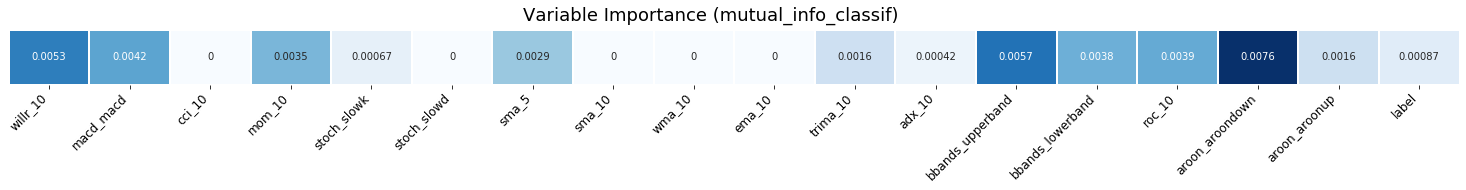

In [4]:
# initial test, but just too simple (correlation would only work in case of linear relationships)
# from sklearn.feature_selection import GenericUnivariateSelect
# trans = GenericUnivariateSelect(score_func=lambda X, y: X.mean(axis=0), mode='percentile', param=50)
# X_trans = trans.fit_transform(X, y)
# print(f'We started with {X.shape[1]} features but retained only {X_trans.shape[1]} of them!')

# this will also work for non-linear relationships
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
from sklearn.feature_selection import GenericUnivariateSelect
df_mutual_information = mutual_info_classif(X, y)

plt.subplots(1, figsize=(26, 1))
sns.heatmap(df_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(df.columns[1:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=50)
X_trans = trans.fit_transform(X, y)

print(f"We started with {X.shape[1] - 1} features but retained only {X_trans.shape[1]} of them!")

columns_retained_Select = df.iloc[:, 1:].columns[trans.get_support()].values
pd.DataFrame(X_trans, columns=columns_retained_Select).head()

In [5]:
# Second test. We'll select the features by running a decision tree.
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
trans = SelectFromModel(clf, threshold='median')
X_trans = trans.fit_transform(X, y)

print(f"We started with {X.shape[1] - 1} features but retained only {X_trans.shape[1]} of them!")

columns_retained_FromMode = df.iloc[:, 1:].columns[trans.get_support()].values
pd.DataFrame(X_trans, columns=columns_retained_FromMode).head()

We started with 17 features but retained only 9 of them!


,willr_10,macd_macd,cci_10,mom_10,stoch_slowd,sma_5,bbands_upperband,bbands_lowerband,aroon_aroondown
0,52.736628,-38.709677,0.009218,21.505376,25.396825,39.947090,18.321473,248.847460,0.016081
1,43.498192,-71.428571,0.005802,-53.587648,13.675214,25.193325,17.430131,248.839848,0.016084
2,41.479735,-73.333333,0.002262,-152.777778,25.796426,21.622822,18.672926,248.837769,0.004021
3,49.318952,-53.333333,0.001856,-32.608696,38.018648,25.830096,17.074255,248.834427,0.012061
4,36.605858,-96.296296,-0.004068,-152.777778,37.041847,33.618974,17.477996,248.830453,-0.056263


In [6]:
# import arff
filename = filename[:10]+'_reduced_featureset'
devsets_path = 'C:\\Users\\suare\\Workspace\\phd_cetrulin\\moa-2017.06-sources\\data\\real\\real_financial_data_not_handling_gaps\\dev_sets\\'
last_arff_created_path = os.path.join('C:\\','Users','suare','Workspace','phd_cetrulin','moa-2017.06-sources','data','real','real_financial_data_not_handling_gaps','dev_sets',f'{filename}')
new_df = pd.DataFrame(X_trans, columns=columns_retained_Select) 
new_df['label'] = y
new_df.to_csv(last_arff_created_path+'.csv', sep=',', encoding='utf-8', index = False)
create_arff_file(last_arff_created_path, output=devsets_path+last_arff_created_path.split(os.sep)[-1]) # export in ARFF
# arff.dump(open(last_arff_created_path, 'w'), new_df, relation="whatever", names=columns_retained_Select+['label'])

NameError: name 'create_arff_file' is not defined

### AutoFeat with 0 feateng_steps
[AutoFeat] The 0 step feature engineering process could generate up to 18 features.
[AutoFeat] With 20364 data points this new feature matrix would use about 0.00 gb of space.
[feateng] Warning: no features generated for max_steps < 1.
[featsel] Scaling data...done.
[featsel] Feature selection run 1/5
[featsel] Feature selection run 2/5
[featsel] Feature selection run 3/5
[featsel] Feature selection run 4/5
[featsel] Feature selection run 5/5
[featsel] 15 features after 5 feature selection runs
[featsel] 7 features after correlation filtering
[featsel] 5 features after noise filtering
[AutoFeat] Final dataframe with 18 feature columns (0 new).
[AutoFeat] Training final classification model.
[AutoFeat] Trained model: largest coefficients:
[-0.00056779]
0.005779 * x000
0.004528 * x001
0.003375 * x005
0.002572 * x002
0.001794 * x016
[AutoFeat] Final score: 0.5264
## Final R^2: 0.5264
### AutoFeat with 1 feateng_steps
[AutoFeat] The 1 step feature engineer

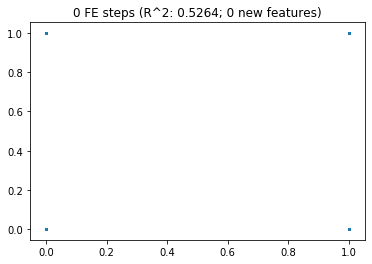

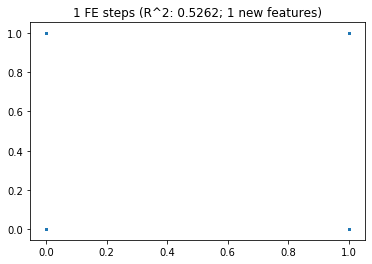

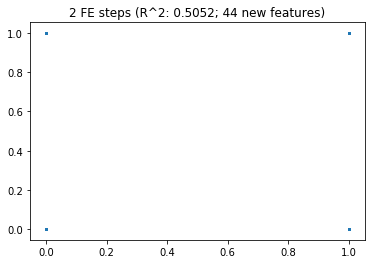

In [7]:
# Try approach 1 (autofit)
# autofeat with different number of feature engineering steps
# 3 are perfect
for steps in range(3):
    np.random.seed(55)
    print("### AutoFeat with %i feateng_steps" % steps)
    afclas = AutoFeatClassifier(verbose=1, feateng_steps=steps)
    df = afclas.fit_transform(X, y)
    r2 = afclas.score(X, y)
    print("## Final R^2: %.4f" % r2)
    plt.figure()
    plt.scatter(afclas.predict(X), y, s=2);
    plt.title("%i FE steps (R^2: %.4f; %i new features)" % (steps, r2, len(afclas.new_feat_cols_)))